In [1]:
# import useful libraries
import numpy as np # linear algebra
from matplotlib import pyplot as plt
from PIL import Image
from glob import glob
import os

# import pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# define paths
train_path = '../intel-image-classification/dataset/dataset/training_parkinsons'
test_path = '../intel-image-classification/dataset/dataset/testing_parkinsons'
pred_path = '../intel-image-classification/dataset/dataset/pred_parkinsons'

In [2]:
transformer = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])

train_loader = DataLoader(
    ImageFolder(train_path, transform=transformer),
    num_workers=8, batch_size=32, shuffle=True
)

test_loader = DataLoader(
    ImageFolder(test_path, transform=transformer),
    num_workers=8, batch_size=32, shuffle=True
)


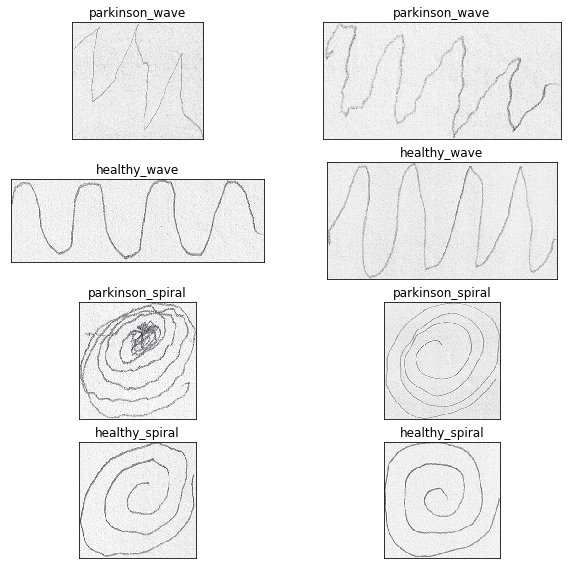

In [3]:
folders = os.listdir(train_path)


images = []
labels = []
for cl in folders:
    path = os.path.join(train_path, cl, '*.png')
    for file in glob(path)[:2]:
        with Image.open(file) as f:
            images.append(np.array(f))
            labels.append(cl)
            
fig = plt.figure(figsize=(10, 15))

for i, image in enumerate(images):
    ax = fig.add_subplot(6, 2, i+1)
    ax.imshow(image)
    ax.set_title(labels[i])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()

In [4]:
resnet_model = models.resnet152(pretrained=True)

# freeze all parameters in ResNet so we won't have to retrain them
for param in resnet_model.parameters():
    param.requires_grad = False

# replace the last layer with another one that will be trainable
in_shape = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_shape, 4)

In [5]:
error = nn.CrossEntropyLoss()
opt = optim.Adam(resnet_model.parameters())

def train(model, train_loader, n_epochs=150):
    model = model.to(device)
    model.train()
    
    for epoch in range(n_epochs):
        epoch_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = error(out, y)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()        
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch: {epoch} \t Train Loss: {epoch_loss:.4g}')
            
train(resnet_model, train_loader)

epoch: 0 	 Train Loss: 6.509
epoch: 15 	 Train Loss: 1.084
epoch: 30 	 Train Loss: 0.5753
epoch: 45 	 Train Loss: 0.3424
epoch: 60 	 Train Loss: 0.3602
epoch: 75 	 Train Loss: 0.2041
epoch: 90 	 Train Loss: 0.4142
epoch: 105 	 Train Loss: 0.3835
epoch: 120 	 Train Loss: 0.1625
epoch: 135 	 Train Loss: 0.3162


In [6]:
def test(model, test_loader):
    model = model.to(device)
    model.eval()
    loss = 0
    for x, y in test_loader:
        with torch.no_grad():
            out = model(x.to(device)).cpu()
        loss += error(out, y)
        
    print(f'Test loss: {loss:.4g}')
    
test(resnet_model, test_loader)

Test loss: 1.303


healthy_spiral


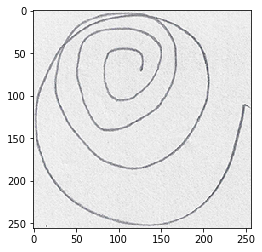

healthy_wave


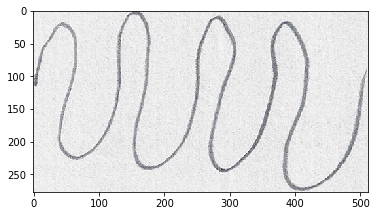

healthy_wave


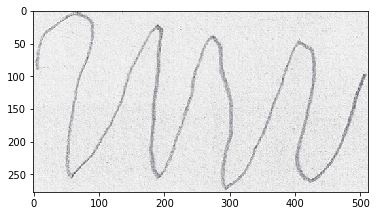

healthy_spiral


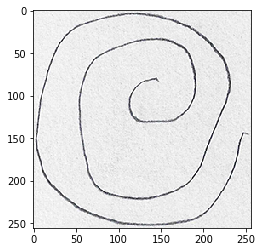

healthy_spiral


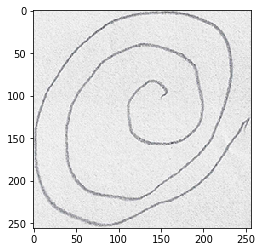

healthy_wave


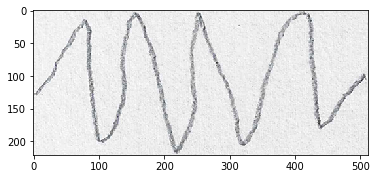

parkinson_spiral


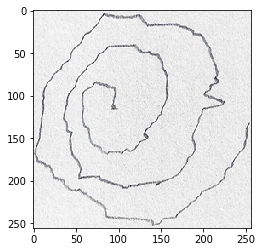

healthy_wave


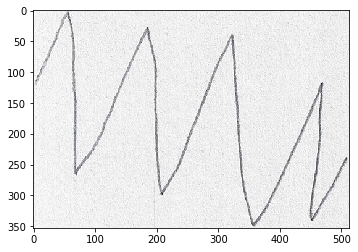

healthy_wave


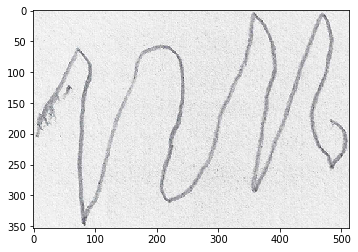

healthy_wave


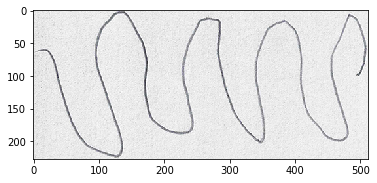

healthy_wave


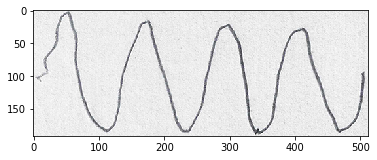

parkinson_spiral


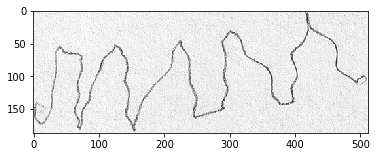

parkinson_wave


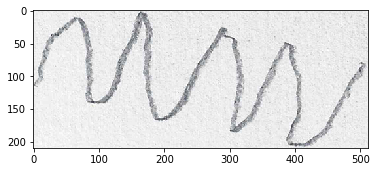

healthy_wave


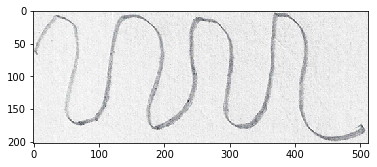

healthy_wave


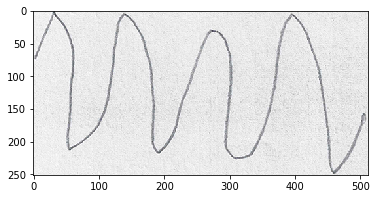

parkinson_spiral


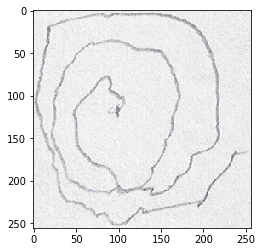

healthy_spiral


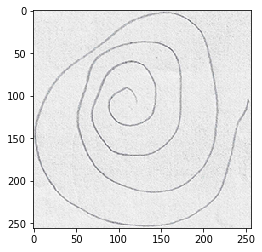

healthy_spiral


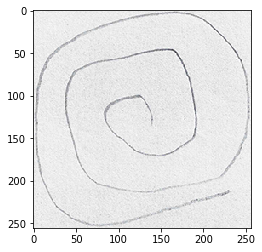

parkinson_wave


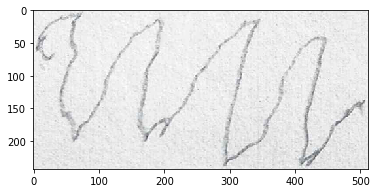

healthy_spiral


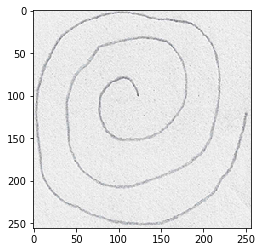

parkinson_spiral


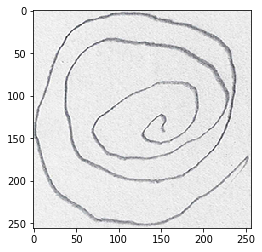

healthy_spiral


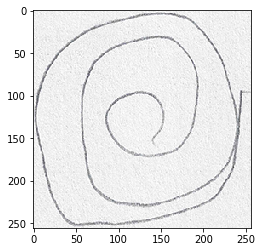

healthy_spiral


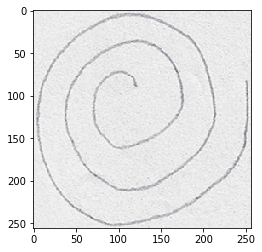

healthy_wave


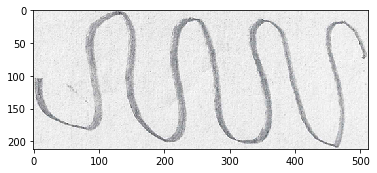

healthy_spiral


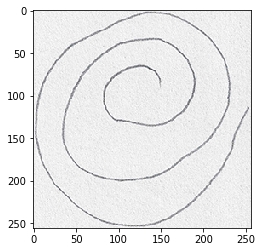

healthy_spiral


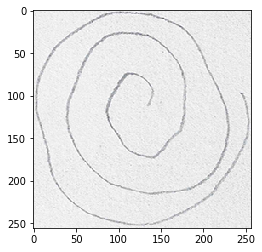

healthy_wave


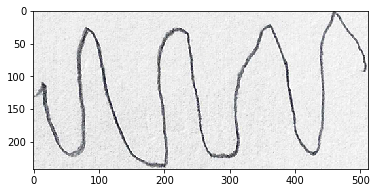

healthy_wave


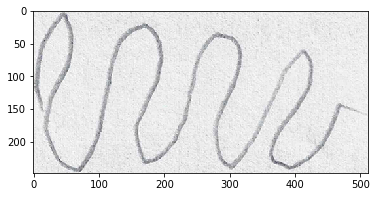

parkinson_wave


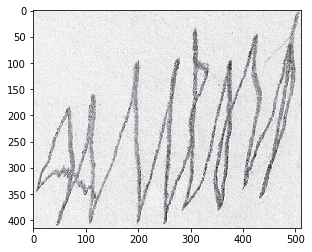

parkinson_wave


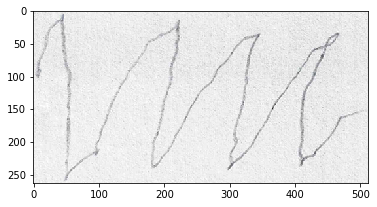

parkinson_wave


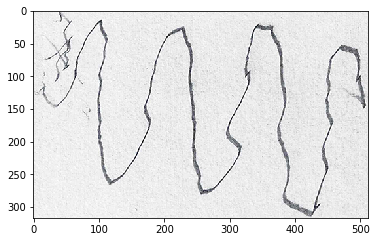

healthy_spiral


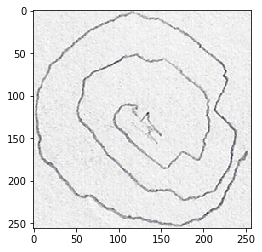

parkinson_spiral


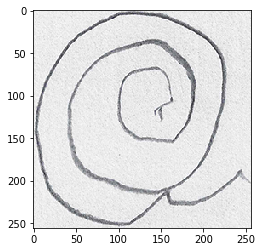

healthy_spiral


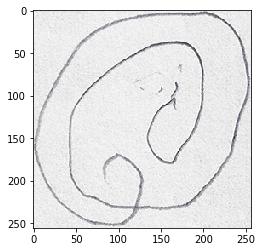

parkinson_spiral


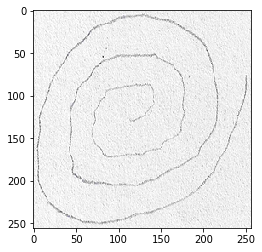

healthy_wave


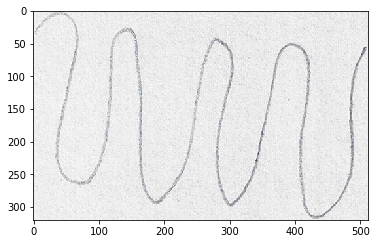

healthy_spiral


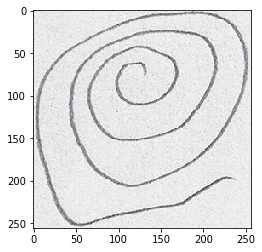

parkinson_spiral


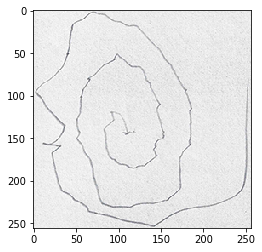

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [7]:
classes = train_loader.dataset.class_to_idx

def predict(model, path, sample_size=59):
    for file in glob(os.path.join(path, '*.png'))[:sample_size]:
        with Image.open(file) as f:
            img = transformer(f).unsqueeze(0)
            with torch.no_grad():
                out = model(img.to(device)).cpu().numpy()
            for key, value in classes.items():
                if value == np.argmax(out):
                    print(key)
            plt.imshow(np.array(f))
            plt.show()
            
predict(resnet_model, pred_path)